In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed = seed

IMG_WIDTH_INPUT = 256
IMG_HEIGHT_INPUT = 256
IMG_CHANNELS_INPUT = 3

IMG_WIDTH_OUTPUT = 256
IMG_HEIGHT_OUTPUT = 256
IMG_CHANNELS_OUTPUT = 1

TRAIN_PATH = '/content/gdrive/MyDrive/train_data/'
TEST_PATH = '/content/gdrive/MyDrive/test_data/'

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
#train dataset
X_train = np.zeros((len(train_ids), IMG_HEIGHT_INPUT, IMG_WIDTH_INPUT, IMG_CHANNELS_INPUT), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT_OUTPUT, IMG_WIDTH_OUTPUT, IMG_CHANNELS_OUTPUT), dtype=np.bool)
print('Resizing train images and masks... \n')
for i, img_name in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + img_name
    img = imread(path + '/images/' + img_name + '.png')[:,:,:IMG_CHANNELS_INPUT]  
    img = resize(img, (IMG_HEIGHT_INPUT, IMG_WIDTH_INPUT), mode='constant', preserve_range=True)
    X_train[i] = img
    mask = np.zeros((IMG_HEIGHT_OUTPUT, IMG_WIDTH_OUTPUT, IMG_CHANNELS_OUTPUT), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT_OUTPUT, IMG_WIDTH_OUTPUT), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
    Y_train[i] = mask
print("done \n")   

Resizing train images and masks... 



100%|██████████| 670/670 [1:07:17<00:00,  6.03s/it]

done 



In [8]:
#test dataset
X_test = np.zeros((len(test_ids), IMG_HEIGHT_INPUT, IMG_WIDTH_INPUT, IMG_CHANNELS_INPUT), dtype=np.uint8)
sizes_test = []
print('Resizing test images...')
for i, img_name in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH + img_name
  img = imread(path + '/images/' + img_name + '.png')[:,:,:IMG_CHANNELS_INPUT]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (IMG_HEIGHT_INPUT, IMG_WIDTH_INPUT), mode='constant', preserve_range=True)
  X_test[i] = img
print("done \n")

Resizing test images...


100%|██████████| 65/65 [00:28<00:00,  2.27it/s]

done 



In [9]:
#input and its transformation
inputs = tf.keras.layers.Input((IMG_HEIGHT_INPUT, IMG_WIDTH_INPUT, IMG_CHANNELS_INPUT))
start = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

#contracting path
d1 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(start)
d1 = tf.keras.layers.Dropout(0.2)(d1)
d1 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(d1)
t12 = tf.keras.layers.MaxPooling2D((2,2))(d1)

d2 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(t12)
d2 = tf.keras.layers.Dropout(0.2)(d2)
d2 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(d2)
t23 = tf.keras.layers.MaxPooling2D((2,2))(d2)

d3 = tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(t23)
d3 = tf.keras.layers.Dropout(0.2)(d3)
d3 = tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(d3)
t34 = tf.keras.layers.MaxPooling2D((2,2))(d3)

d4 = tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(t34)
d4 = tf.keras.layers.Dropout(0.2)(d4)
d4 = tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(d4)
t45 = tf.keras.layers.MaxPooling2D((2,2))(d4)

d5 = tf.keras.layers.Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(t45)
d5 = tf.keras.layers.Dropout(0.2)(d5)
d5 = tf.keras.layers.Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(d5)

#upscaling path
u4 = tf.keras.layers.Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(d5)
#d4 = tf.keras.layers.Cropping2D(cropping=((1,0),(1,0)))(d4)
u4 = tf.keras.layers.concatenate([d4, u4])
u4 = tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u4)

u3 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(u4)
d3 = tf.keras.layers.Cropping2D(cropping=((1,2),(1,2)))(d3)
#u3 = tf.keras.layers.concatenate([d3, u3])
u3 = tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u3)

u2 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(u3)
#d2 = tf.keras.layers.Cropping2D(cropping=((3,3),(3,3)))(d2)
u2 = tf.keras.layers.concatenate([d2, u2])
u2 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u2)

u1 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(u2)
#d1 = tf.keras.layers.Cropping2D(cropping=((6,6),(6,6)))(d1)
u1 = tf.keras.layers.concatenate([d1, u1])
u1 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding = 'same')(u1)

#output
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(u1)

#model
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [10]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_dsbowl2018.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train,
                    validation_split=0.1,
                    batch_size=16,
                    epochs=15,
                    callbacks=[earlystopper, checkpointer],
                    verbose=1)

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8279
Epoch 00001: val_loss improved from inf to 0.26689, saving model to model_dsbowl2018.h5
38/38 [==============================] - 150s 4s/step - loss: 0.4341 - accuracy: 0.8279 - val_loss: 0.2669 - val_accuracy: 0.8956
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9045
Epoch 00002: val_loss improved from 0.26689 to 0.17075, saving model to model_dsbowl2018.h5
38/38 [==============================] - 148s 4s/step - loss: 0.2452 - accuracy: 0.9045 - val_loss: 0.1707 - val_accuracy: 0.9424
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9327
Epoch 00003: val_loss improved from 0.17075 to 0.13200, saving model to model_dsbowl2018.h5
38/38 [==============================] - 149s 4s/step - loss: 0.1811 - accuracy: 0.9327 - val_loss: 0.1320 - val_accuracy: 0.9473
Epoch 4/15
38/38 [==============================] - ETA:

In [11]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)

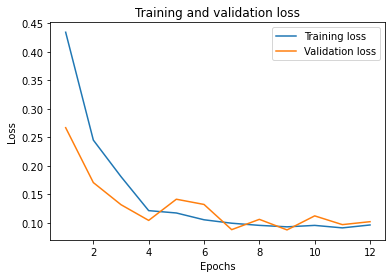

In [12]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
best_model = tf.keras.models.load_model('model_dsbowl2018.h5')
best_model.save('/content/gdrive/MyDrive/bowl_best_model/')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/bowl_best_model/assets


In [14]:
best_model = tf.keras.models.load_model('model_dsbowl2018.h5')
preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = best_model.predict(X_test, verbose=1)

3/3 [==============================] - 2s 593ms/step


In [15]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [16]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

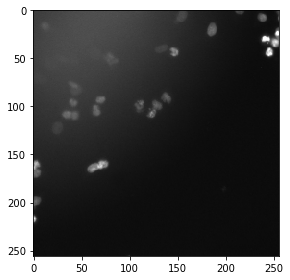

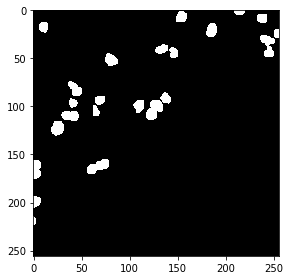

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


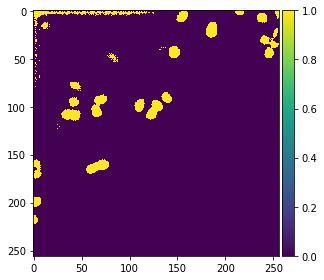

In [17]:
#ix = random.randint(0, len(preds_train_t))
ix = 0
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

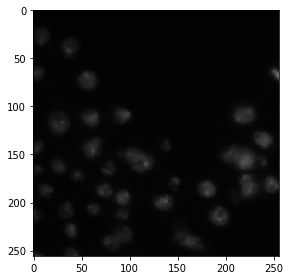

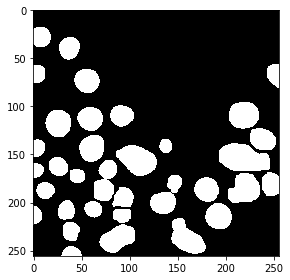

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


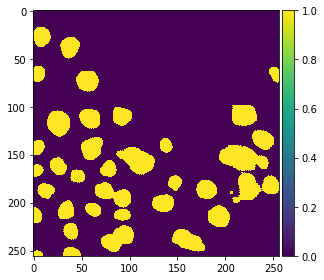

In [18]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()